In [59]:
#All the required libraries are imported here
from google.colab import drive
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import Dataset
from torchvision.transforms import ToPILImage, Compose, ToTensor, Resize, Normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms
from PIL import Image
import seaborn as sns

In [ ]:
#References
#https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/
#https://stackoverflow.com/questions/53673575/in-place-shuffle-torch-tensor-in-the-order-of-a-numpy-ndarray
#https://medium.com/swlh/introduction-to-cnn-image-classification-using-cnn-in-pytorch-11eefae6d83c
#
#
#https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [60]:
#Setting the path up for the dataset. Dataset is in Goole Drive
drive.mount('/content/drive', force_remount=True)
dir_path = "/content/drive/My Drive/Face Mask Detection/Datasets"
save_dir = "/content/drive/My Drive/Face Mask Detection/loaded_images.npy"
model_dir = "/content/drive/My Drive/Face Mask Detection/saved_model"
sample_image_path = "/content/drive/My Drive/Face Mask Detection/test"

Mounted at /content/drive


In [63]:
#get four categories of data 
def get_data_class(dir_path):
  classes = os.listdir(dir_path)
  print(classes)
  return classes

In [62]:
#Here, we will zip labels and classes(category) of data
def set_labels_and_zip_class_and_label(data_class):
  label = [i for i in range(len(data_class))]
  print(label)

  label_dict = dict(zip(data_class,label))
  print(label_dict)
  
  return label_dict 

In [65]:
#Retreiving image from the specified path and then appending the image to its label into a numpy array.
def load_image(data_class, dir_path, label_dict):
  data = []
  labels = []
  for label in tqdm(data_class):
    data_path = os.path.join(dir_path, label)
    image_names = os.listdir(data_path)
    
    for image in tqdm(image_names):
      image_path = os.path.join(data_path, image)
      images = cv2.imread(image_path) 
      try:
        imag = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
        img = cv2.resize(imag, (100,100))
        
        data.append((img, label_dict[label]))
      except Exception as e:
        print(e)

  return data

In [67]:
#Shuffles the data and then save it to a pre-specified path
def shuffle_and_save_data(data, save_dir):
  np.random.shuffle(data)  
  np.save(save_dir, data)


In [68]:
#Customized Dataset class to set and get the data.
class FaceMaskDataset(Dataset):
  #saving the data
  def __init__(self, data):
    self.data = data
    self.transformation = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                                   transforms.Resize((100,100))
                                   ])
  
  def __getitem__(self, id):
    return self.transformation(self.data[id][0]), torch.tensor(self.data[id][1])
  
  def __len__(self):
    return self.data.__len__()


In [70]:
#CNN Architecture to train the model.
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv_layer = nn.Sequential(
        #Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        #Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    
        #Layer 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    
    #Fully Connected Layer
    self.linear_layers = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(256 * 12 * 12, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 64),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(64,10)
    )

  def forward(self, x):
    x = self.conv_layer(x)
    #print(x.shape)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)
    return x

In [71]:
#This will load the saved data and then split it into two parts and then load the data 
#using DataLoader() method with some batch_size.
def data_loader(save_dir):
  data = np.load(save_dir, allow_pickle=True)

  training_data, testing_data = train_test_split(data, test_size = 0.3, random_state = 0)

  training_dataset = FaceMaskDataset(training_data)
  testing_dataset = FaceMaskDataset(testing_data)

  train_loader = DataLoader(training_dataset, batch_size=32)
  test_loader = DataLoader(testing_dataset, batch_size=32)

  return train_loader, test_loader

In [72]:
#This method will train the dataset according to the specified epoch number.
def model_trainer(train_loader, test_loader, epoch_number):
  model = CNN()

  loss_criteria = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  total_step = len(train_loader)
  training_accuracy_list = []
  training_loss_list = []

  for epoch in range(epoch_number):
    for i, (images, labels) in enumerate(train_loader):
      outputs = model(images)

      #Forward Pass
      training_loss = loss_criteria(outputs, labels)
      training_loss_list.append(training_loss.item())

      #Backpropogation and Optimization
      optimizer.zero_grad()
      training_loss.backward()
      optimizer.step()

      #Training Accuracy
      total = labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted == labels).sum().item()
      training_accuracy_list.append(correct / total)

    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
        .format(epoch + 1, epoch_number, training_loss.item(),
        (correct / total) * 100))

  return model
  

In [73]:
#This method will save the model onto a pre-specified path.
def save_model(model, model_name, model_save_dir):
  torch.save(model.state_dict(), "{}/{}".format(model_save_dir, model_name))    

In [75]:
#Confusion Matrix - Accuracy, f-measure, recall and precision and also plotting confusion Matrix
def generate_matrix(model, title, data_loader, classes):
  model.eval()
  prediction_list = []
  accurate_list = []
  with torch.no_grad():
    for images, labels in data_loader:
      outputs = model(images)
      _, predicted = torch.max(model(images), 1)
      prediction_list.extend(predicted.detach().cpu().numpy())
      accurate_list.extend(labels.detach().cpu().numpy())
  
  print("{} Classification Report: ".format(title))
  print(classification_report(prediction_list, accurate_list))
  print("{} Confusion Matrix: ".format(title))
  
  confusion_matrix_data = confusion_matrix(accurate_list, prediction_list)
 
  #Plotting confusion matrix
  conf_matrix = sns.heatmap(confusion_matrix_data, annot=True, fmt='g' )

  conf_matrix.set_title('Confusion Matrix with labels!!');
  conf_matrix.set_xlabel('Predicted Categories')
  conf_matrix.set_ylabel('Actual Categories');

  conf_matrix.xaxis.set_ticklabels(['Cloth Mask', 'Surgical Mask', 'Without a Mask', 'FFP2 Mask'])
  conf_matrix.yaxis.set_ticklabels(['Cloth Mask', 'Surgical Mask', 'Without a Mask', 'FFP2 Mask'])

  plt.setp(conf_matrix.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
  plt.setp(conf_matrix.get_yticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
  
  plt.show()

In [76]:
#This method will predict some unlabelled images' categories.
def predict_image(image_path, model, data_classes):
  image_names = os.listdir(image_path)
  label = {i for i in range(len(data_classes))}
  label_dict = dict(zip(label,data_classes))
  print("Prediction Time: ")
  for images in image_names:
    loader = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                                   transforms.Resize((100,100))
                              ])
    image_name = os.path.join(sample_image_path, images)
    image = Image.open(image_name)
    image.show()
    image = loader(image).float()
    image = image.unsqueeze(0)

    _, predicted = torch.max(model(image), dim=1)

    pre = predicted[0]
    key = pre.item()
    
    print(images,"  ->  ", label_dict[key])
    

In [77]:
def FaceMaskDetection():
  if torch.cuda.is_available():
    device = torch.device('cuda')
  else:
    device = torch.device('cpu')
  
  print("Data Categories:")
  data_classes = get_data_class(dir_path)
  
  print("Data Categories and its labels:")
  data_labels = set_labels_and_zip_class_and_label(data_classes)
      
  print("Loading each image and mapping to its label:")      
  data = load_image(data_classes, dir_path, data_labels)
  
  print("Shuffling and saving the data:")
  shuffle_and_save_data(data, save_dir)
      
  print("loading the dataset:")
  train_loader, test_loader = data_loader(save_dir)
  
  print("Training the model:")
  model = model_trainer(train_loader, test_loader, epoch_number = 30)
  
  model = model.to(device)
  model_name = "COMP6721-AI-Project-1"
  print("Saving the trained model:")
  save_model(model, model_name, model_dir)
      
  generate_matrix(model, "training", train_loader, data_classes)
  generate_matrix(model, "testing", test_loader, data_classes)
  
  print("Classifying the Images:")
  predict_image(sample_image_path, model, data_classes)
    
    

Data Categories:
['cloth_mask', 'surgical_mask', 'without_mask', 'ffp2_mask']
Data Categories and its labels:
[0, 1, 2, 3]
{'cloth_mask': 0, 'surgical_mask': 1, 'without_mask': 2, 'ffp2_mask': 3}
Loading each image and mapping to its label:


 24%|██▍       | 80/330 [00:01<00:04, 56.04it/s]

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'




100%|██████████| 4/4 [00:23<00:00,  5.77s/it]
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Shuffling and saving the data:
loading the dataset:
Training the model:
Epoch [1/30], Loss: 1.0531, Accuracy: 67.74%
Epoch [2/30], Loss: 0.8493, Accuracy: 70.97%
Epoch [3/30], Loss: 0.6786, Accuracy: 74.19%
Epoch [4/30], Loss: 0.6503, Accuracy: 80.65%
Epoch [5/30], Loss: 0.4899, Accuracy: 77.42%
Epoch [6/30], Loss: 0.3725, Accuracy: 87.10%
Epoch [7/30], Loss: 0.5581, Accuracy: 83.87%
Epoch [8/30], Loss: 0.4192, Accuracy: 87.10%
Epoch [9/30], Loss: 0.4169, Accuracy: 83.87%
Epoch [10/30], Loss: 0.3840, Accuracy: 77.42%
Epoch [11/30], Loss: 0.3122, Accuracy: 83.87%
Epoch [12/30], Loss: 0.4220, Accuracy: 87.10%
Epoch [13/30], Loss: 0.2782, Accuracy: 87.10%
Epoch [14/30], Loss: 0.2465, Accuracy: 90.32%
Epoch [15/30], Loss: 0.1259, Accuracy: 93.55%
Epoch [16/30], Loss: 0.1514, Accuracy: 90.32%
Epoch [17/30], Loss: 0.1779, Accuracy: 96.77%
Epoch [18/30], Loss: 0.1080, Accuracy: 93.55%
Epoch [19/30], Loss: 0.0670, Accuracy: 96.77%
Epoch [20/30], Loss: 0.0688, Accuracy: 96.77%
Epoch [21/30], Lo

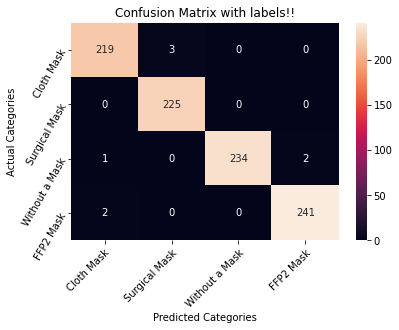

testing Classification Report: 
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       105
           1       0.84      0.79      0.82       115
           2       0.87      0.93      0.90        89
           3       0.58      0.56      0.57        89

    accuracy                           0.75       398
   macro avg       0.74      0.75      0.75       398
weighted avg       0.75      0.75      0.75       398

testing Confusion Matrix: 


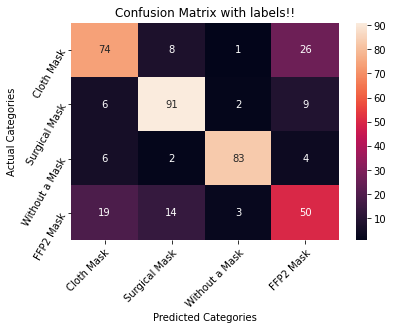

Classifying the Images:
Prediction Time: 
cloth_1.jpg   ->   cloth_mask
person_1.jpg   ->   ffp2_mask
surgical_1.jpg   ->   surgical_mask
surgical_2.jpg   ->   surgical_mask
surgical_3.jpg   ->   surgical_mask
ffp2_1.jpeg   ->   surgical_mask
ffp2_2.jpeg   ->   surgical_mask
ffp2_3.jpeg   ->   cloth_mask
person_2.jpg   ->   cloth_mask
person_3.jpg   ->   without_mask
cloth_2.jpg   ->   cloth_mask
cloth_3.jpg   ->   cloth_mask


In [78]:
FaceMaskDetection()